# Detecting Fake News

## DTSA 5510 Final Project

### Thesis
With this being another election year, I wanted to take a look at fake news. I intend to create an unspervised model to be able to detect fake news based on news from around the previous election cycle, April 1, 2016 - September 9, 2017

### Dataset Analysis
The Dataset I used is the fake-and-real-news-dataset available on Kaggle. https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

The dataset comtains examples from 23480 true sources and 21416 fake sources. I chose to classify each row of these dataframes and then combine them into a larger dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
#Import and get genral info
fakeDF = pd.read_csv('Fake.csv')
fakeDF.info()

trueDF = pd.read_csv('True.csv')
trueDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [3]:
#Verify time frame from the dataset
print(trueDF['date'].min())
print(trueDF['date'].max())

April 1, 2016 
September 9, 2017 


In [4]:
#  classify and combine the datasets
fakeDF['type'] = 0
trueDF['type'] = 1

combineDF =  pd.concat([fakeDF, trueDF])

combineDF = combineDF.sample(frac=1).reset_index(drop=True)

### Clean the Data
To clean the data, I started by importing a list of stopwords. With this, I went through the each article and removed punctuation and numbers. I then converted it to lowecase and removed the stopwords. I added the title to the start of the cleaned text. Finally i vectorized the dataframe.

In [5]:
#Clean the data using stopwords and regex
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')  # Download stopwords if not already downloaded
stop_words = list(stopwords.words('english'))

def remove_stopwords(text):
        words = word_tokenize(text)

        filtered_words = [word for word in words if word.lower() not in stop_words]
        
        return ' '.join(filtered_words)

def clean_text(df, col):
    clean_text = df[col]
    clean_text = clean_text.apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    clean_text = clean_text.apply(lambda row: re.sub(r'[0-9]+', '', row))
    clean_text = clean_text.apply(lambda x: x.lower())
    clean_text = clean_text.apply(lambda x: remove_stopwords(x))
    
    return clean_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Edward\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Edward\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
combineDF['cleantext'] = clean_text(combineDF,'text')

In [7]:
combineDF['cleantext'] = combineDF['title'] + ' ' + combineDF['text']
trainDF = combineDF[['type', 'cleantext']]

In [8]:
#Vectorization Eval

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(
    max_df=.5,
    max_features=3000,
    min_df = 19,
)

X_tfidf = vectorizer.fit_transform(trainDF['cleantext'])
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

n_samples: 44898, n_features: 3000


### Modeling
After the vecotrization, I built a kmeans model to evaluate the language of each article. Through this process, I was able to adjust the parameters to find a solution that could predict with an over 85% accuracy that something was copnsidered fake.

In [9]:
#create kmeans model and associate labels
from sklearn.cluster import KMeans

kmeans_title = KMeans(
    n_clusters=2,
    max_iter=10,
    n_init=3
).fit(X_tfidf)

kmeans_pred = kmeans_title.labels_

In [10]:
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn

def label_permute_compare(yt,yp):
    labels = np.unique(yt)
    perms = itertools.permutations(labels, len(labels))
    best = 0
    best_perm = []
    for perm in perms:
        y = np.array([perm[label] for label in yp])
        acc = np.mean(y == yt)
        if acc > best:
            best = acc
            best_perm = list(perm)
    return best_perm, best

Accuracy:  85.1 %


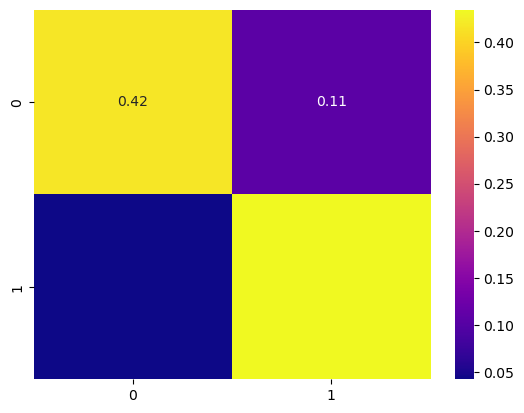

In [20]:
import matplotlib.pyplot as plt
label_order_text, text_acc = label_permute_compare(trainDF['type'].values,kmeans_pred)
kmeans_pred_labels = np.array([label_order_text[label] for label in kmeans_pred])

print('Accuracy: ', int(text_acc*1000)/10,'%')

text_cm = confusion_matrix(trainDF['type'].values,kmeans_pred_labels)/len(kmeans_pred_labels)
sn.heatmap(text_cm, cmap = 'plasma', annot=True)
plt.show()

In [12]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2,
          random_state=100,
          init='nndsvda', 
          solver = 'mu',
          beta_loss = 'kullback-leibler')
nmf.fit(X_tfidf)

NMF(beta_loss='kullback-leibler', init='nndsvda', n_components=2,
    random_state=100, solver='mu')

Accuracy:  86.5 %


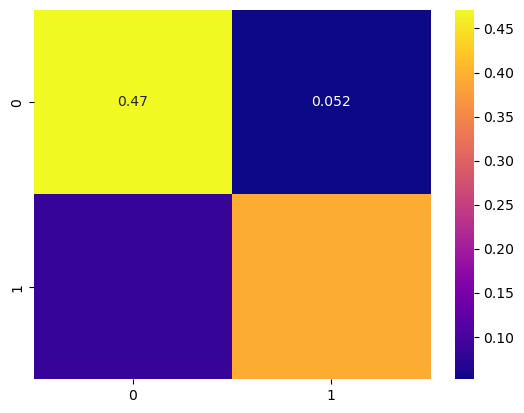

In [19]:
x= nmf.transform(X_tfidf)
nmf_pred = 1*(x[:,0]>x[:,1])

label_order_text, text_acc = label_permute_compare(trainDF['type'].values,nmf_pred)
text_pred_labels = np.array([label_order_text[label] for label in nmf_pred])

print('Accuracy: ', int(text_acc*1000)/10,'%')

text_cm = confusion_matrix(trainDF['type'].values,text_pred_labels)/len(text_pred_labels)
sn.heatmap(text_cm, cmap='plasma', annot=True)
plt.show()

### Comparison to Supervised Learning
With this being a categorization issue, I wanted to take a few minutes to look at what supervised learning would be able to accomplish with this issue.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

test_train_ratio = np.linspace(0.1, 0.9, 9)

test_accuracy = []
cms = []

for x in test_train_ratio:
    
    X_train, X_test, Y_train, Y_test = train_test_split(trainDF['cleantext'],trainDF['type'], test_size = x, random_state = 42,shuffle=True)
    
    rfc = Pipeline([('tfidf', vectorizer),
                ('rfc', RandomForestClassifier(n_estimators=100)),
               ])

    rfc.fit(X_train, Y_train)

    test_predict = rfc.predict(X_test)

    test_accuracy.append(accuracy_score(test_predict, Y_test)*100)
    
    cms.append( [x,confusion_matrix(Y_test,test_predict)/len(test_predict)])

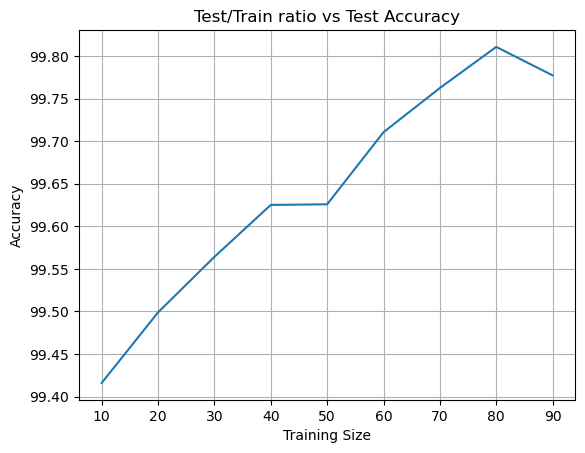

In [18]:
plt.figure()
plt.grid()
plt.plot(100-test_train_ratio*100,test_accuracy)
plt.title('Test/Train ratio vs Test Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.show()


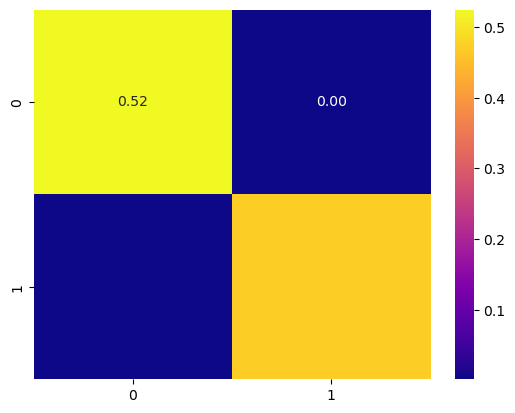

In [16]:
sn.heatmap(cms[5][1], cmap='plasma', annot=True, fmt='.2f')
plt.show()

### Conclusion
In conclusion, there seems to be some clear patterns about what language is frequently used in fake news articles. The model was able to find patterns and determine, with reasnoable accuracy, whether an article was real or fake. In the future, I would hope to be able to have a more diverse dataset to be able to evaluate groups of words and phrases to be able to better identify fake news. 